<a href="https://colab.research.google.com/github/AlifeviousChristian/Batteries-State-Of-Health-Estimation/blob/main/LSTM_Charging80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation of The Dataset

In [1]:
# To install the kaggle connnector

!pip install kaggle

In [2]:
# To allow the GDrive connection to this notebook

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# This is to configure that our dataset will be saved at /content/drive/MyDrive/Thesis

import os
os.chdir("/content/drive/MyDrive/Thesis")

## Analyzing the data and creating the LSTM model
Refer to https://youtu.be/c0k-YLQGKjY?si=7rK46NGHURBgLNE2

In [4]:
# This is to import all necesary libraries

import tensorflow as tf
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Thesis/80SOCDatasetOnly.csv") #Based on the dataset information, all value is in MWs
df

,Time (s),SoC
0,0.0,84.33
1,1.0,84.33
2,2.0,84.33
3,3.0,84.33
4,4.0,86.57
...,...,...
197,197.0,100.00
198,198.0,100.00
199,199.0,100.00
200,200.0,99.25


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df

,Time (s),SoC
0,0.0,84.33
1,1.0,84.33
2,2.0,84.33
3,3.0,84.33
4,4.0,86.57
...,...,...
197,197.0,100.00
198,198.0,100.00
199,199.0,100.00
200,200.0,99.25


<Axes: >

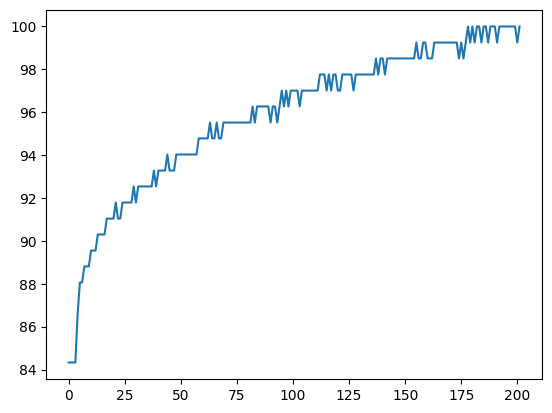

In [8]:
elec = df['SoC'] # All values devided by 1000 to normalize the data since our the data is quite big
elec.plot() # Plot the dataset

In [9]:
# We are going to create a matrix like bellow :
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=3):
  df_as_np = df.to_numpy()
  X = []
  y = []

  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [10]:
WINDOW_SIZE = 3
X1, y1 = df_to_X_y(elec, WINDOW_SIZE)
X1.shape, y1.shape

((199, 3, 1), (199,))

In [11]:
# This is to devide the dataset into train, validation, and test set.

X_train1, y_train1 = X1[:120], y1[:120]
X_val1, y_val1 = X1[120:150], y1[120:150]
X_test1, y_test1 = X1[150:], y1[150:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((120, 3, 1), (120,), (30, 3, 1), (30,), (49, 3, 1), (49,))

In [12]:
# Creating a LSTM model using tensorflow-keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model5 = Sequential()
model5.add(InputLayer((3, 1)))
model5.add(LSTM(64))
model5.add(Dense(8, 'relu'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Configuring the optimizer

cp1 = ModelCheckpoint('model5/model.keras', save_best_only=True) # Add '.keras' to the end of the filepath
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history=model5.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=500, callbacks=[cp1])
model5.save('model5/model.keras') #This will save your model

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - loss: 8699.6562 - root_mean_squared_error: 93.2719 - val_loss: 9423.4395 - val_root_mean_squared_error: 97.0744
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 8693.9336 - root_mean_squared_error: 93.2411 - val_loss: 9388.4707 - val_root_mean_squared_error: 96.8941
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 8655.5166 - root_mean_squared_error: 93.0347 - val_loss: 9362.3760 - val_root_mean_squared_error: 96.7594
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 8643.3359 - root_mean_squared_error: 92.9693 - val_loss: 9337.0664 - val_root_mean_squared_error: 96.6285
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 8543.7402 - root_mean_squared_error: 92.4319 - val_loss: 9311.5625 - val_root_mean_squared_error: 96.4964
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 8527.9736 - root_mean_squared_error: 92.3467 - val_loss: 9283.8877 - val_root_mean_squared_error: 96.3529
Epoch 7/500
4/4

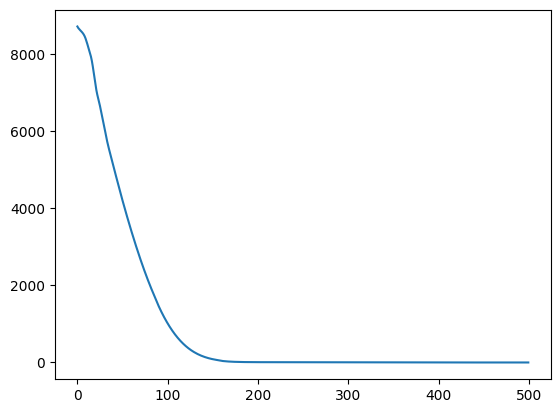

In [14]:
# To load trained model
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
model5 = load_model('model5/model.keras')

loss_per_epoch = history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [15]:
train_predictions = model5.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train predictions':train_predictions, 'Actuals':y_train1})
train_results['Error'] = abs(train_results['Actuals'] - train_results['Train predictions'])
train_results['Percentage Error (%)'] = (train_results['Error'] / train_results['Actuals']) * 100
train_results

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


,Train predictions,Actuals,Error,Percentage Error (%)
0,86.803207,84.33,2.473207,2.932773
1,86.803207,86.57,0.233207,0.269386
2,87.215988,88.06,0.844012,0.958451
3,88.207100,88.06,0.147100,0.167045
4,88.682526,88.81,0.127474,0.143536
...,...,...,...,...
115,97.098831,97.76,0.661169,0.676318
116,97.114273,97.76,0.645727,0.660523
117,97.289871,97.01,0.279871,0.288497
118,97.085541,97.01,0.075541,0.077869


In [16]:
import matplotlib.pyplot as plt


avg_error = train_results['Error'].mean()
max_error = train_results['Error'].max()
min_error = train_results['Error'].min()

print(f"Average Error: {avg_error}")
print(f"Maximum Error: {max_error}")
print(f"Minimum Error: {min_error}")

Average Error: 0.3544082438151049
Maximum Error: 2.473207397460939
Minimum Error: 0.056264343261716476


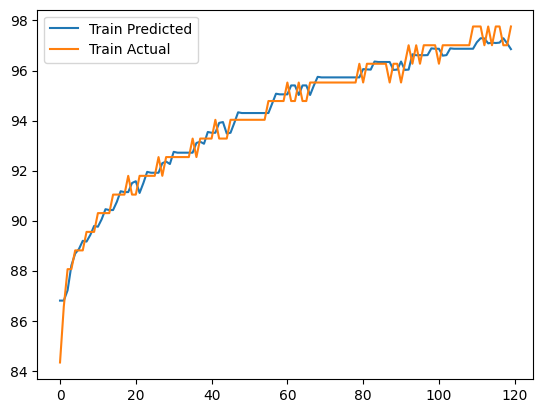

In [17]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train predictions'], label='Train Predicted')
plt.plot(train_results['Actuals'], label='Train Actual')
plt.legend()

In [18]:
val_predictions = model5.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val predictions':val_predictions, 'Actuals':y_val1})
val_results['Error val'] = abs(val_results['Actuals'] - val_results['Val predictions'])
val_results['Percentage Error val (%)'] = (val_results['Error val'] / val_results['Actuals']) * 100
val_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


,Val predictions,Actuals,Error val,Percentage Error val (%)
0,97.128189,97.76,0.631811,0.646288
1,97.289871,97.76,0.470129,0.480901
2,97.281693,97.76,0.478307,0.489267
3,97.281693,97.76,0.478307,0.489267
4,97.281693,97.01,0.271693,0.280066
5,97.085541,97.76,0.674459,0.689913
6,97.114273,97.76,0.645727,0.660523
7,97.289871,97.76,0.470129,0.480901
8,97.281693,97.76,0.478307,0.489267
9,97.281693,97.76,0.478307,0.489267


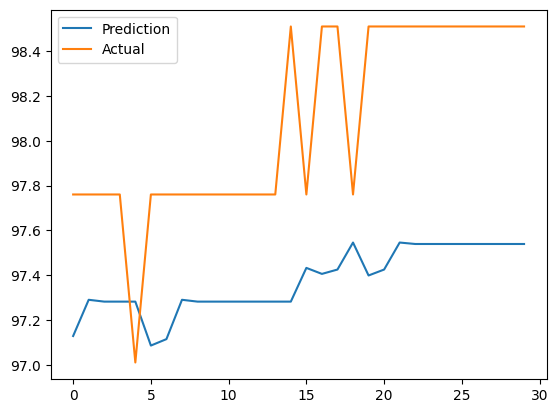

In [19]:
import matplotlib.pyplot as plt
plt.plot(val_results['Val predictions'][:1000], label='Prediction') # Changed 'Train Predictions' to 'Train Predicted'
plt.plot(val_results['Actuals'][:1000], label='Actual') # Changed 'Actuals' to 'Train Actual'
plt.legend()

In [20]:
test_predictions = model5.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test predictions':test_predictions, 'Actuals':y_test1})
test_results['Error test'] = abs(test_results['Actuals'] - test_results['Test predictions'])
test_results['Percentage Error val (%)'] = (test_results['Error test'] / val_results['Actuals']) * 100
test_results

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


,Test predictions,Actuals,Error test,Percentage Error val (%)
0,97.538963,98.51,0.971037,0.993286
1,97.538963,98.51,0.971037,0.993286
2,97.538963,99.25,1.711037,1.750242
3,97.663681,98.51,0.846319,0.865711
4,97.637115,98.51,0.872885,0.899788
5,97.532669,99.25,1.717331,1.756681
6,97.663681,99.25,1.586319,1.622667
7,97.752869,98.51,0.757131,0.774480
8,97.631607,98.51,0.878393,0.898520
9,97.532669,98.51,0.977331,0.999725


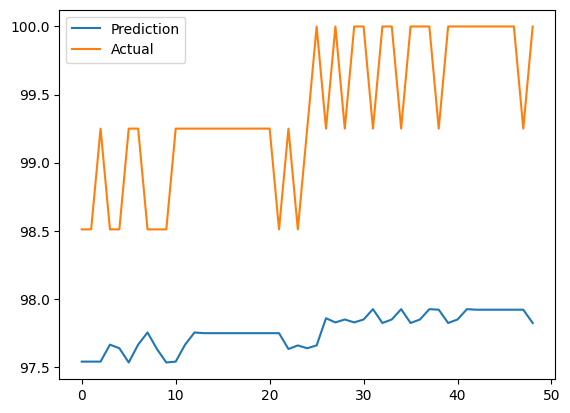

In [21]:
import matplotlib.pyplot as plt
plt.plot(test_results['Test predictions'][:7800], label='Prediction') # Changed 'Train Predictions' to 'Train Predicted'
plt.plot(test_results['Actuals'][:7800], label='Actual') # Changed 'Actuals' to 'Train Actual'
plt.legend()

Analyzing the data and creating the CNN model

## Analyzing the data and creating the CNN model
Refer to https://www.youtube.com/watch?v=kGdbPnMCdOg&t=1320s

In [22]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions(model, X, y, start=0, end=7800):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions': predictions, 'Actuals': y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    plt.legend(['Predictions', 'Actuals'])
    return df, mse(y, predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


(    Predictions  Actuals
 0     97.538963    98.51
 1     97.538963    98.51
 2     97.538963    99.25
 3     97.663681    98.51
 4     97.637115    98.51
 5     97.532669    99.25
 6     97.663681    99.25
 7     97.752869    98.51
 8     97.631607    98.51
 9     97.532669    98.51
 10    97.538963    99.25
 11    97.663681    99.25
 12    97.752869    99.25
 13    97.747833    99.25
 14    97.747833    99.25
 15    97.747833    99.25
 16    97.747833    99.25
 17    97.747833    99.25
 18    97.747833    99.25
 19    97.747833    99.25
 20    97.747833    99.25
 21    97.747833    98.51
 22    97.631607    99.25
 23    97.657928    98.51
 24    97.637115    99.25
 25    97.657928   100.00
 26    97.857391    99.25
 27    97.826904   100.00
 28    97.848267    99.25
 29    97.826904   100.00
 30    97.848267   100.00
 31    97.924179    99.25
 32    97.822540   100.00
 33    97.848267   100.00
 34    97.924179    99.25
 35    97.822540   100.00
 36    97.848267   100.00
 37    97.92

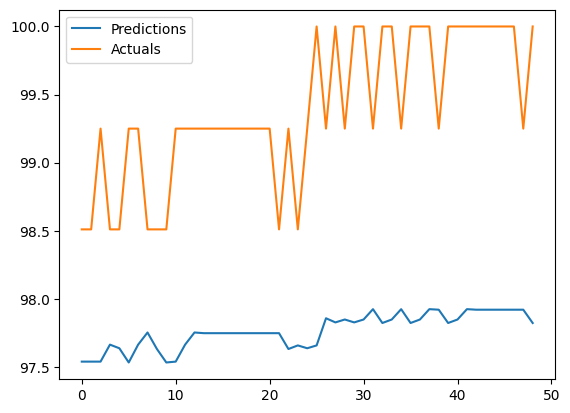

In [23]:
plot_predictions(model5, X_test1, y_test1)

In [24]:
model6 = Sequential()
model6.add(InputLayer((3, 1)))
model6.add(Conv1D(64, kernel_size = 2))
model6.add(Flatten())
model6.add(Dense(8, 'relu'))
model6.add(Dense(1, 'linear'))

model6.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,233 (4.82 KB)

 Trainable params: 1,233 (4.82 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Configuring the optimizer

cp2 = ModelCheckpoint('model6/model.keras', save_best_only=True) # Add '.keras' to the end of the filepath
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history2=model6.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=500, callbacks=[cp2])
model6.save('model6/model.keras') #This will save your model

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 9513.1045 - root_mean_squared_error: 97.5016 - val_loss: 7393.7598 - val_root_mean_squared_error: 85.9870
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 6241.9658 - root_mean_squared_error: 78.9732 - val_loss: 5199.3389 - val_root_mean_squared_error: 72.1064
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4606.7183 - root_mean_squared_error: 67.8650 - val_loss: 4161.1182 - val_root_mean_squared_error: 64.5067
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3655.8835 - root_mean_squared_error: 60.4539 - val_loss: 3204.3132 - val_root_mean_squared_error: 56.6067
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2784.8428 - root_mean_squared_error: 52.7626 - val_loss: 2363.5432 - val_root_mean_squared_error: 48.6163
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2035.0930 - root_mean_squared_error: 45.1019 - val_loss: 1654.9164 - val_root_mean_squared_error: 40.6807
Epoch 7/500
4/4

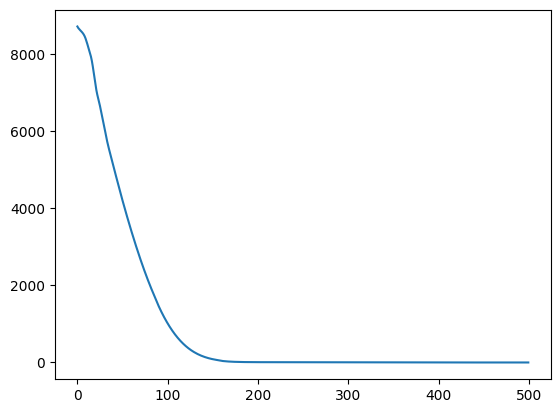

In [26]:
# To load trained model
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
model6 = load_model('model6/model.keras')

loss_per_epoch = history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [27]:
test_predictions2 = model6.predict(X_test1).flatten()
test_results2 = pd.DataFrame(data={'Test predictions':test_predictions2, 'Actuals':y_test1})
test_results2['Error test'] = test_results2['Actuals'] - test_results2['Test predictions']
test_results2['Percentage Error test (%)'] = (test_results2['Error test'] / test_results2['Actuals']) * 100
test_results2

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


,Test predictions,Actuals,Error test,Percentage Error test (%)
0,98.695244,98.51,-0.185244,-0.188046
1,98.695244,98.51,-0.185244,-0.188046
2,98.695244,99.25,0.554756,0.558948
3,98.942780,98.51,-0.432780,-0.439325
4,98.996513,98.51,-0.486513,-0.493872
5,98.885536,99.25,0.364464,0.367218
6,98.942780,99.25,0.307220,0.309542
7,99.244072,98.51,-0.734072,-0.745175
8,99.186806,98.51,-0.676806,-0.687043
9,98.885536,98.51,-0.375536,-0.381216


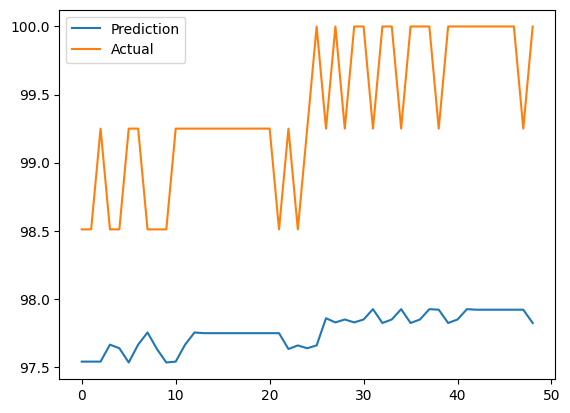

In [28]:
import matplotlib.pyplot as plt
plt.plot(test_results['Test predictions'][:7800], label='Prediction') # Changed 'Train Predictions' to 'Train Predicted'
plt.plot(test_results['Actuals'][:7800], label='Actual') # Changed 'Actuals' to 'Train Actual'
plt.legend()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


(    Predictions  Actuals
 0     98.695244    98.51
 1     98.695244    98.51
 2     98.695244    99.25
 3     98.942780    98.51
 4     98.996513    98.51
 5     98.885536    99.25
 6     98.942780    99.25
 7     99.244072    98.51
 8     99.186806    98.51
 9     98.885536    98.51
 10    98.695244    99.25
 11    98.942780    99.25
 12    99.244072    99.25
 13    99.434372    99.25
 14    99.434372    99.25
 15    99.434372    99.25
 16    99.434372    99.25
 17    99.434372    99.25
 18    99.434372    99.25
 19    99.434372    99.25
 20    99.434372    99.25
 21    99.434372    98.51
 22    99.186806    99.25
 23    99.133072    98.51
 24    98.996513    99.25
 25    99.133072   100.00
 26    99.494972    99.25
 27    99.739716   100.00
 28    99.878136    99.25
 29    99.739716   100.00
 30    99.878136   100.00
 31    99.990623    99.25
 32    99.932579   100.00
 33    99.878136   100.00
 34    99.990608    99.25
 35    99.932579   100.00
 36    99.878136   100.00
 37    99.99

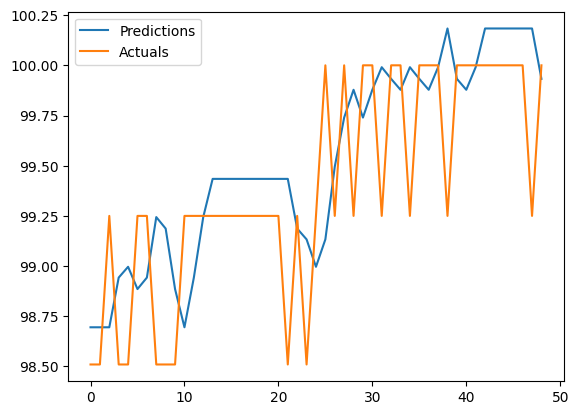

In [29]:
plot_predictions(model6, X_test1, y_test1)

In [30]:
import matplotlib.pyplot as plt

avg_error = test_results2['Percentage Error test (%)'].mean()
max_error = test_results2['Percentage Error test (%)'].max()
min_error = test_results2['Percentage Error test (%)'].min()

print(f"Average Error: {abs(avg_error)}","%")
print(f"Maximum Error: {max_error}","%")
print(f"Minimum Error: {abs(min_error)}","%")

Average Error: 0.13791062865079576 %
Maximum Error: 0.8669281005859375 %
Minimum Error: 0.940533308898772 %


Analyzing